# Demonstration: Intro to Goodness of Fit

First we have our standard header with common import statements, and a statement to make plots look nice.

In [1]:
# standard import statements
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as opt
import classlib4334

# jupyter-specific display instructions
%config InlineBackend.figure_format = 'retina'

# my personal defaults
mpl.rcParams['figure.figsize'] = (5.5, 3.5)
mpl.rcParams['font.size'] = 9
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 5

## Basic Fitted Curve

We start by revisiting the data and fitted linear model from the last lesson:

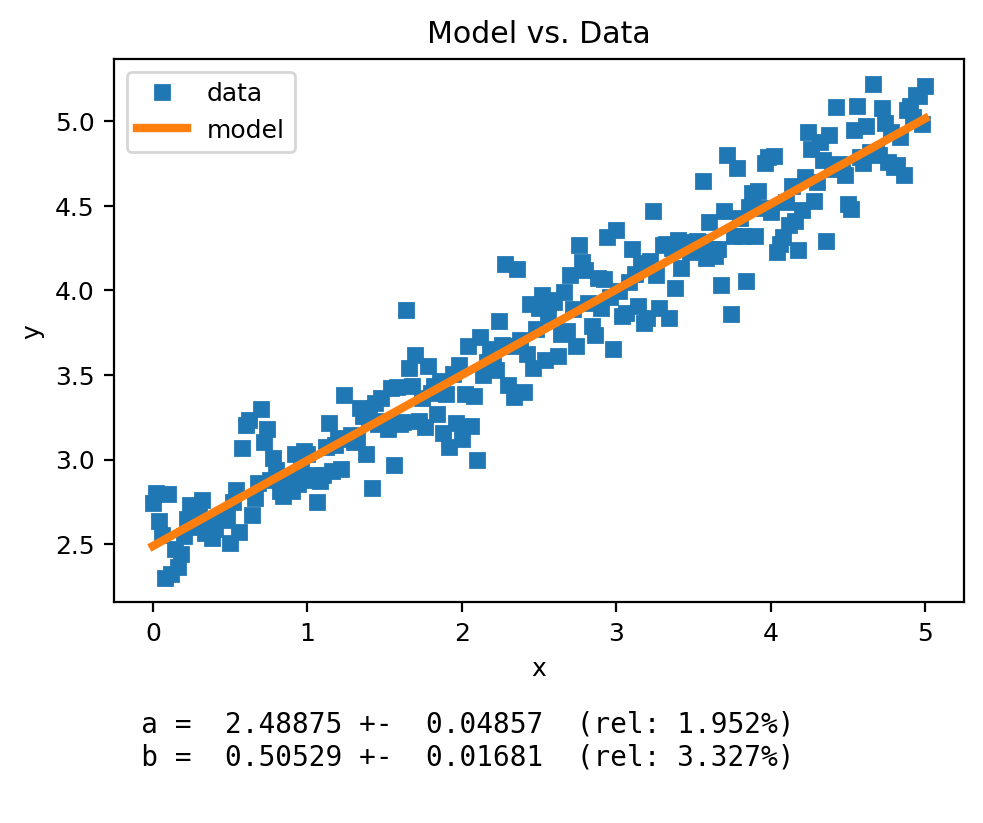

In [2]:
# read data from excel file, and convert to numpy arrays
excel_file = 'data/demo-intro-jupyter-pandas.xlsx'
mydata = pd.read_excel(excel_file)
x = np.array(mydata['x'])
y = np.array(mydata['y'])

x = np.linspace(0, 5, 251)
y = 2.5 + 0.5*x + np.random.normal(0, .2, len(x))


# create a linear model
def linear_model(x, a, b):
    return a + b*x

# fit the model and plot it
pfit, perr = classlib4334.fit_and_plot(linear_model, x, y)

## Plots of the residual

Now, as we saw previously, the fitted values of $a$ and $b$ are obtained by minimizing the sum of squares of the *residual*, which is defined as the vertical distances between the data points and the model curve.  It is highly useful to plot the residual itself.

[NOTE:  this is often done using the predicted values along the x-axis, rather than the independent variable.  For a linear regression, the two are simply a linear transform of one another, and using the predicted values continues working when there are multiple independent variables.]

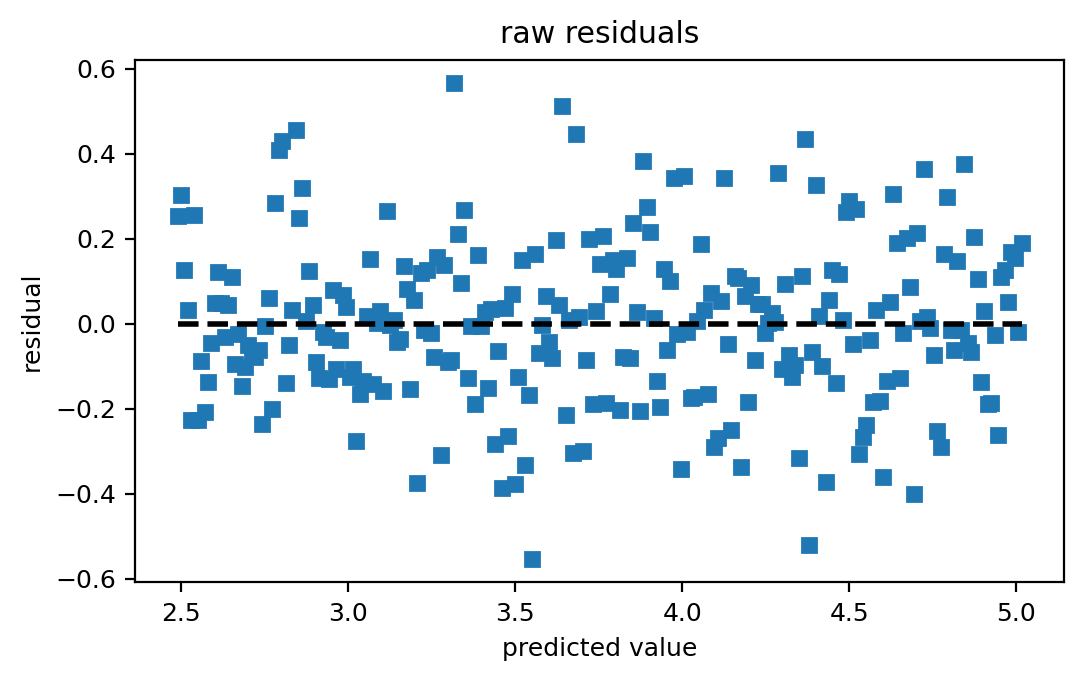

In [3]:
# calculate the residual
pred  = linear_model(x, *pfit)
resid = y - pred

# plot fitted model vs data
fig, ax = plt.subplots()
ax.plot(pred, resid, 's', label='residual')
ax.plot(pred, 0*resid, 'k--', linewidth=2)
ax.set_xlabel('predicted value')
ax.set_ylabel('residual')
ax.set_title('raw residuals')
fig.tight_layout()
plt.show()

We hope to see several qualitative features in this plot
* **lack of structure** the values should look random, and not like they are following some function
* **uniformity** the nature of the randomness should be the same throughout the domain
* **compactness** there should be no obvious outliers in the residual

This residual plot looks pretty decent.  There is one point that looks slightly like an outlier, and maybe the eyes suggest a faint curved shape, but they are very slight.

## A quantitative metric

This is all fine, but it would also be nice to have some kind of quantitative measure of how well our model did.  We of course have the quantity we were trying to minimize:  the sum of squares of the residual:
$$E_{2}^2 = \sum \left( y_i - f(x_i) \right)^2$$
But how do we know what if the minimal value of this quantity is "good enough"?  Won't it change with the number of data points, and the nature of the data and the errors?  It would be nice if we could convert this quantity into a number we can reliably interpret.

To do so, we divide the value of $E_2^2$ for our model with the value we would have gotten from the simplest non-trivial model possible, which is simply the mean value of the data.  This gives us a quantity called the **Unexplained Variance Ratio**:
$$UVR = \frac{SS_\mathrm{res}}{SS_\mathrm{tot}} = \frac{ \sum_1^N (y_i - f(x_i))^2}{ \sum_1^N (y_i - \left< y \right>)^2}$$
We can see that a "best-possible" model exhibiting $f(x_i) = y_i$ would have UVR=0, whereas a "simplest-possible" model $f(x_i) = \left< y_i \right>$ would have UVR=1.  We have *normalized* the error so that it lives on the interval $x\in[0,1]$.

The reason for this name can be understood if we multiply both top and bottom by $\frac{1}{N}$, obtaining
$$UVR = \frac{\frac{1}{N} \sum_1^N (y_i - f(x_i))^2}{\frac{1}{N} \sum_1^N (y_i - \left< y \right>)^2}$$
Now we see that the denominator is simply the *variance* -- about the mean -- of the original data, whereas the numerator can be thought of as the "variance about the model."  The better the model, the more of the variation within the data is captured by the model, and the less of that variation remains within the residual.

Finally, instead of reporting *how small is the error*, it is more common to report *how good is the model*.  This is done using the **Explained Variance Ratio**
$$R^2 = EVR = 1-UVR = 1 - \frac{SS_\mathrm{res}}{SS_\mathrm{tot}}$$
This number, also known by its symbol "R-squared", is defined as "the percentage of overall variation of the dependent variable that can be explained by the variation of the independent variable."

Let's now compute it for our data and model.  It's easy to do:

In [4]:
# calculate the R-squared value
ymean = np.mean(y)
ssres = np.sum( (y - pred)**2 )
sstot = np.sum( (y - ymean)**2 )
rsqrd = 1 - ssres / sstot

print("explained variance ratio is: %8.8f" % rsqrd)

explained variance ratio is: 0.92280001


## Another helper function

As with curve fitting in the last lesson, I've provided you with a helper function in our class library to automate this process.  In fact, it is the same function!  Just add the argument "residual=True" to the function call, and it will appear right next to the graph comparing the model and data.

When you are working in Jupyter on a project, it is often a good idea to look at the residual each time you compare a model and data.  However, for display in a report, you typically would not include the plot of the residual, unless it were really important to your narrative.

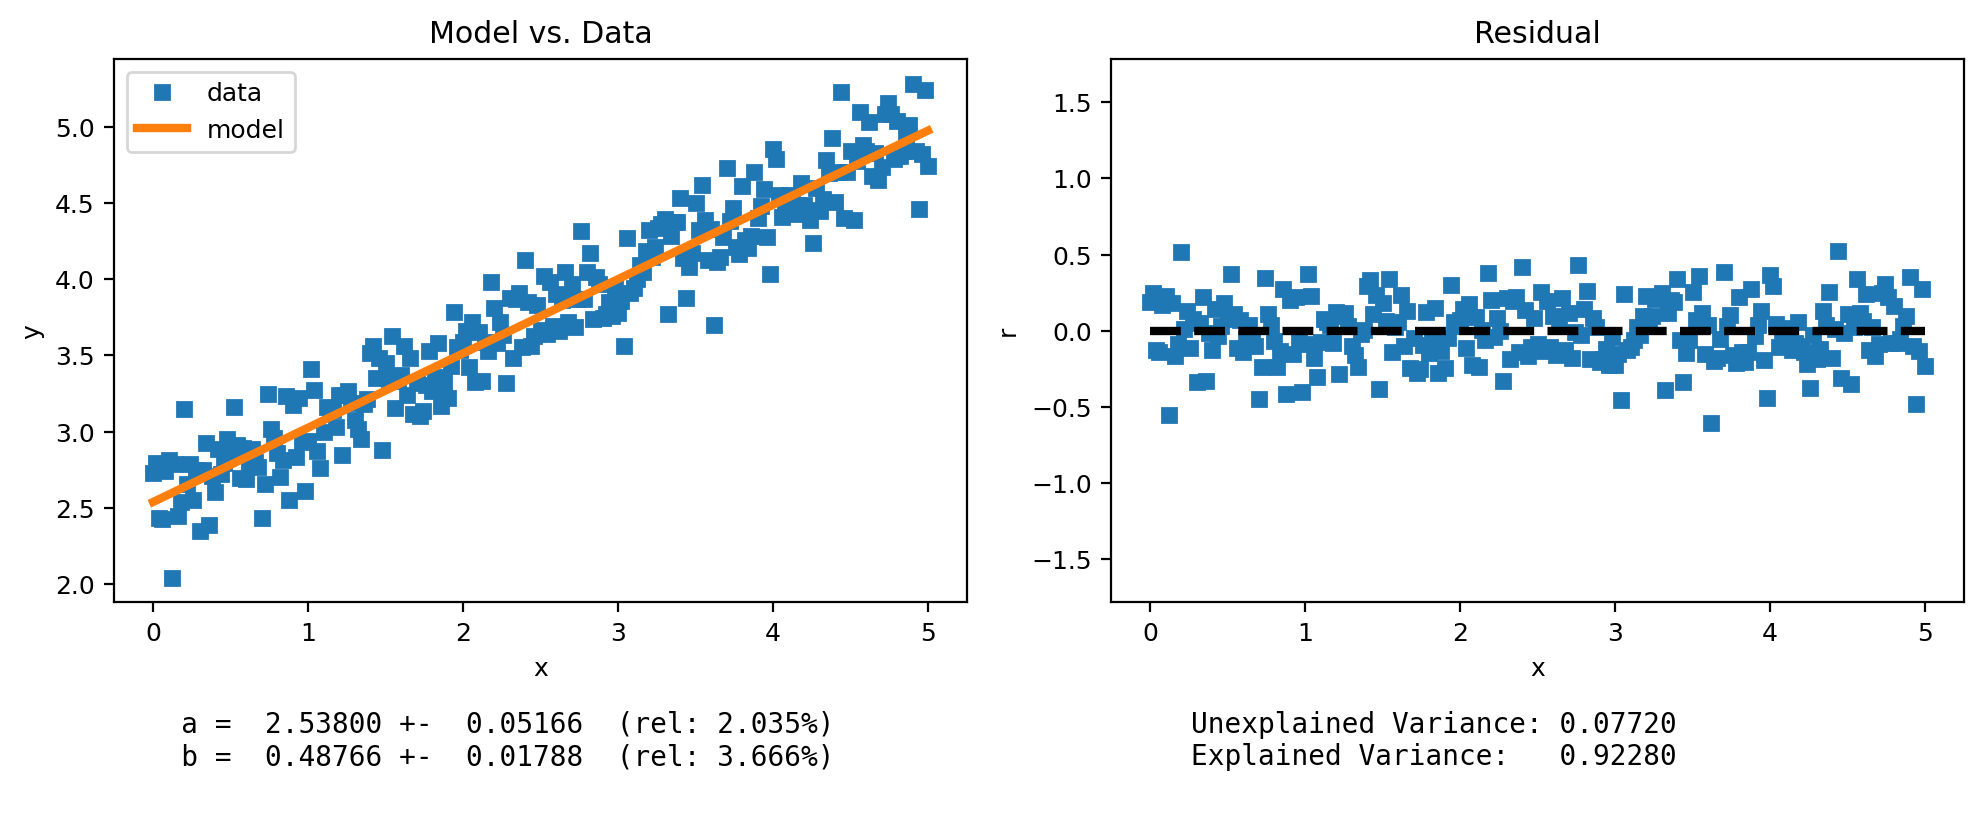

In [5]:
pfit, perr = classlib4334.fit_and_plot(linear_model, x, y, residual=True)


## Going Further:  Testing for normality

Ideally, the values of the residual will be *normally distributed* around zero.  We can roughly check this using a histogram of the residual values:

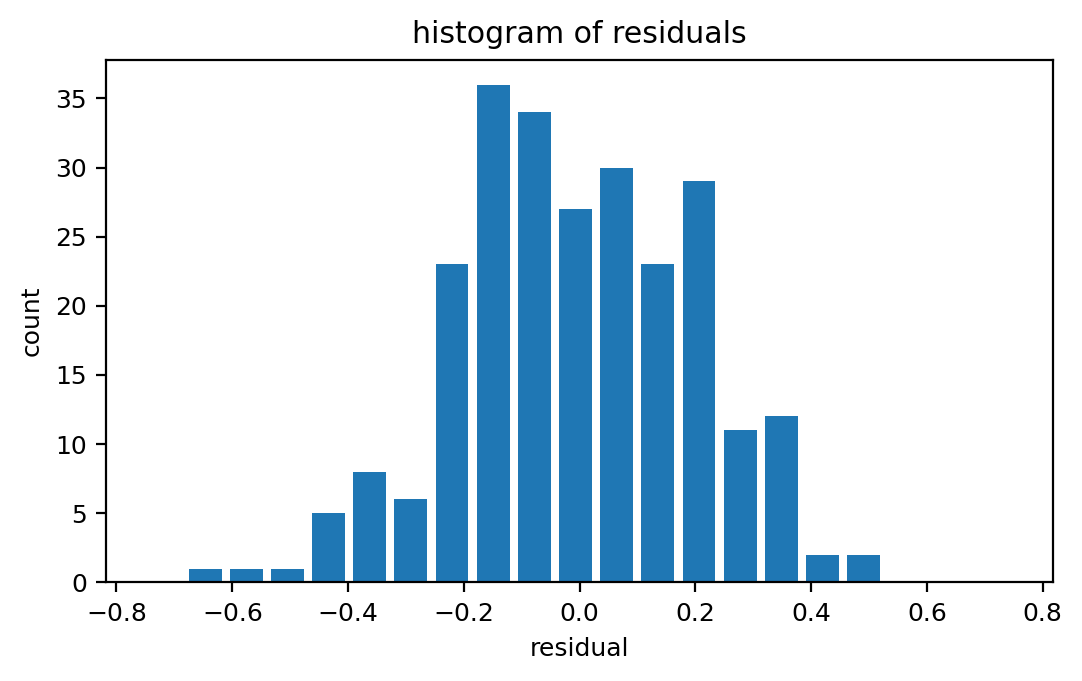

In [6]:
resid = y-pred
r_range = np.max(resid) - np.min(resid)
rmean  = np.mean(resid)
rstd   = np.std(resid)

bincount = int(np.floor(1.5*np.sqrt(len(resid))))
binedges = np.linspace(rmean-4*rstd, rmean+4*rstd, bincount+1)
binwidth = rstd*8/bincount

fig, ax = plt.subplots()
ax.hist(resid, binedges, width=0.8*binwidth)
ax.set_xlim(binedges[0], binedges[-1])
ax.set_xlabel('residual')
ax.set_ylabel('count')
ax.set_title('histogram of residuals')
fig.tight_layout()
plt.show()

That looks ... maybe normal?  It can be hard to tell just by looking at the distribution.  So a final graph that is also often included compares the actual residual values with those that would be *expected* in a normal distribution with mean $\mu$ and standard deviation $\sigma$: 

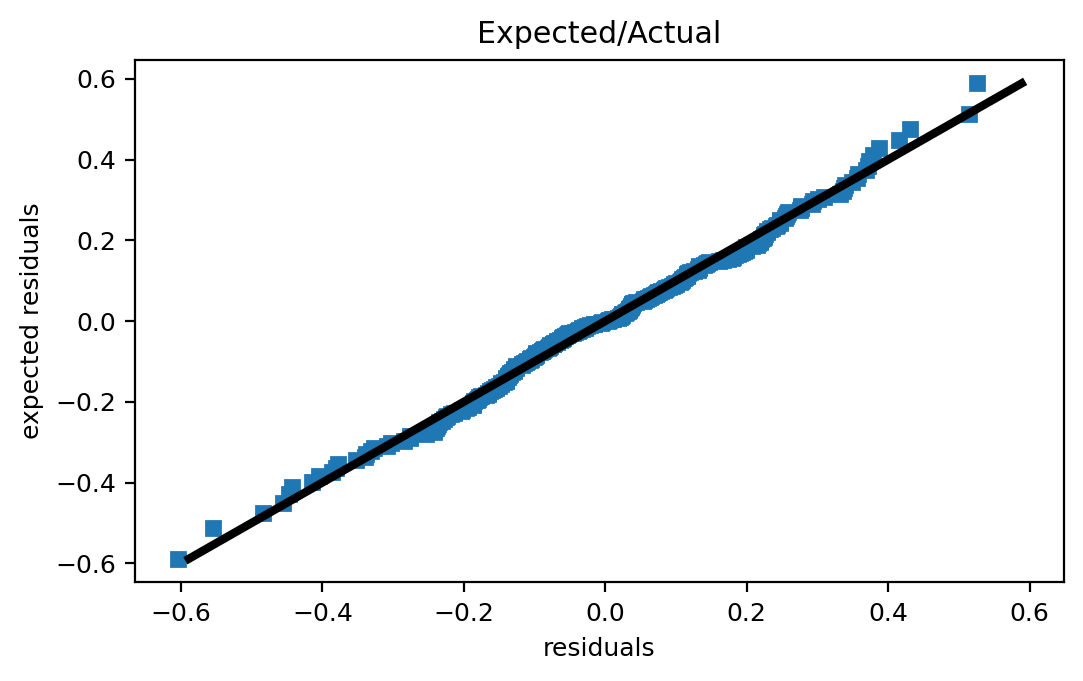

In [8]:
# get a sorted version of the residual values
rsort = sorted(resid)

# compute the mean and standard deviation of the residual
rmean = np.mean(resid)
rstd  = np.std(resid)

# generate the expected residual values
NPTS  = len(resid)
sortpctle = np.linspace(0+.5/NPTS,1-0.5/NPTS, NPTS)
import scipy.special as spc
resids_p = rmean + rstd * np.sqrt(2) * spc.erfinv(2*sortpctle - 1)   # you don't need to understand this!!

# create a plot comparing the two quantities
plt.figure()
plt.plot(rsort, resids_p, 's')
plt.plot(resids_p, resids_p, 'k')
plt.xlabel('residuals')
plt.ylabel('expected residuals')
plt.title('Expected/Actual')
plt.tight_layout()
plt.show()

Reflecting this desire for normality, it is customary when plotting the residuals themselves (above) to display what are known as "standardized residuals," given by the formula

$$r_i^\text{std} = \frac{r_i - \left<r\right>}{\sigma}$$

where $\left<r\right>$ is the mean of the residual and $\sigma$ is its standard deviation.  That is, we are plotting the number of standard deviations away from the mean of each component of the residual (this is also known as the "Z-score").  When plotted this way, we expect around 99.5% of the points to lie within the interval $[-3, 3]$.  An example of this kind of plot is shown below.

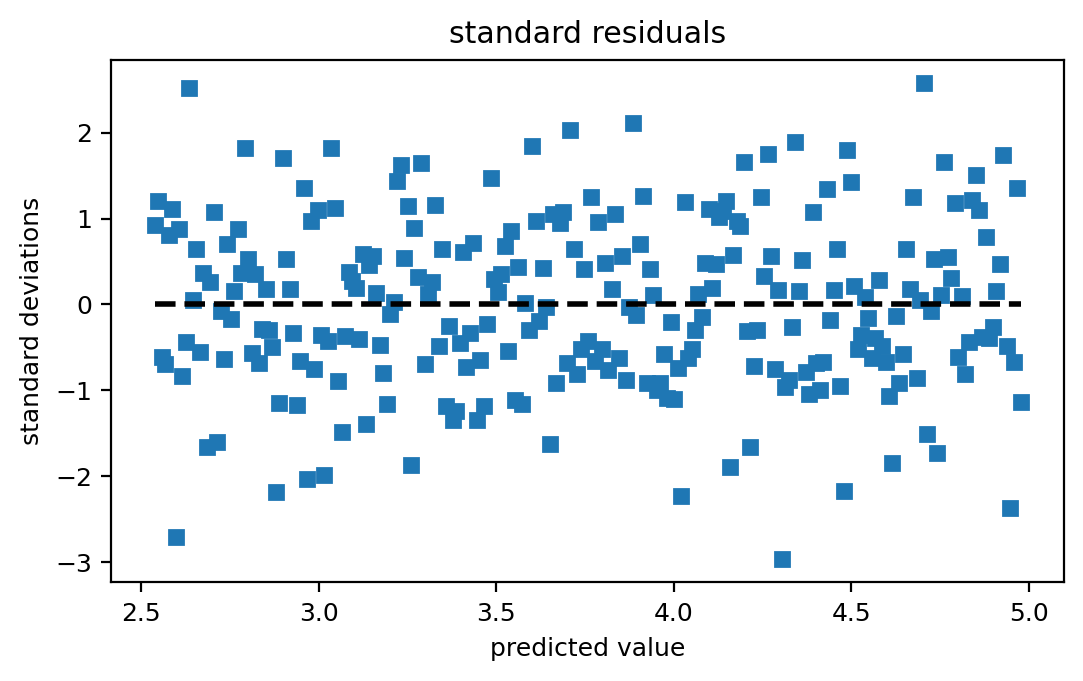

In [9]:
# compute standardized residuals
resid  = y - pred
rmean  = np.mean(resid)
rstd   = np.std(resid)
stdres = (resid - rmean) / rstd

# plot fitted model vs data
fig, ax = plt.subplots()
ax.plot(pred, stdres, 's')
ax.plot(pred, 0*x, 'k--', linewidth=2)
ax.set_xlabel('predicted value')
ax.set_ylabel('standard deviations')
ax.set_title(r'standard residuals')

fig.tight_layout()
plt.show()

Finally, instead of plotting the residual against the independent variable $x_i$, it is customary to plot the residual against the predicted values of the dependent variable, $\hat{y}_i$.  In general, this is convenient because it continues to work when there are *multiple independent variables*.

All of the things described in this advanced section may be viewed together by calling another helper function:

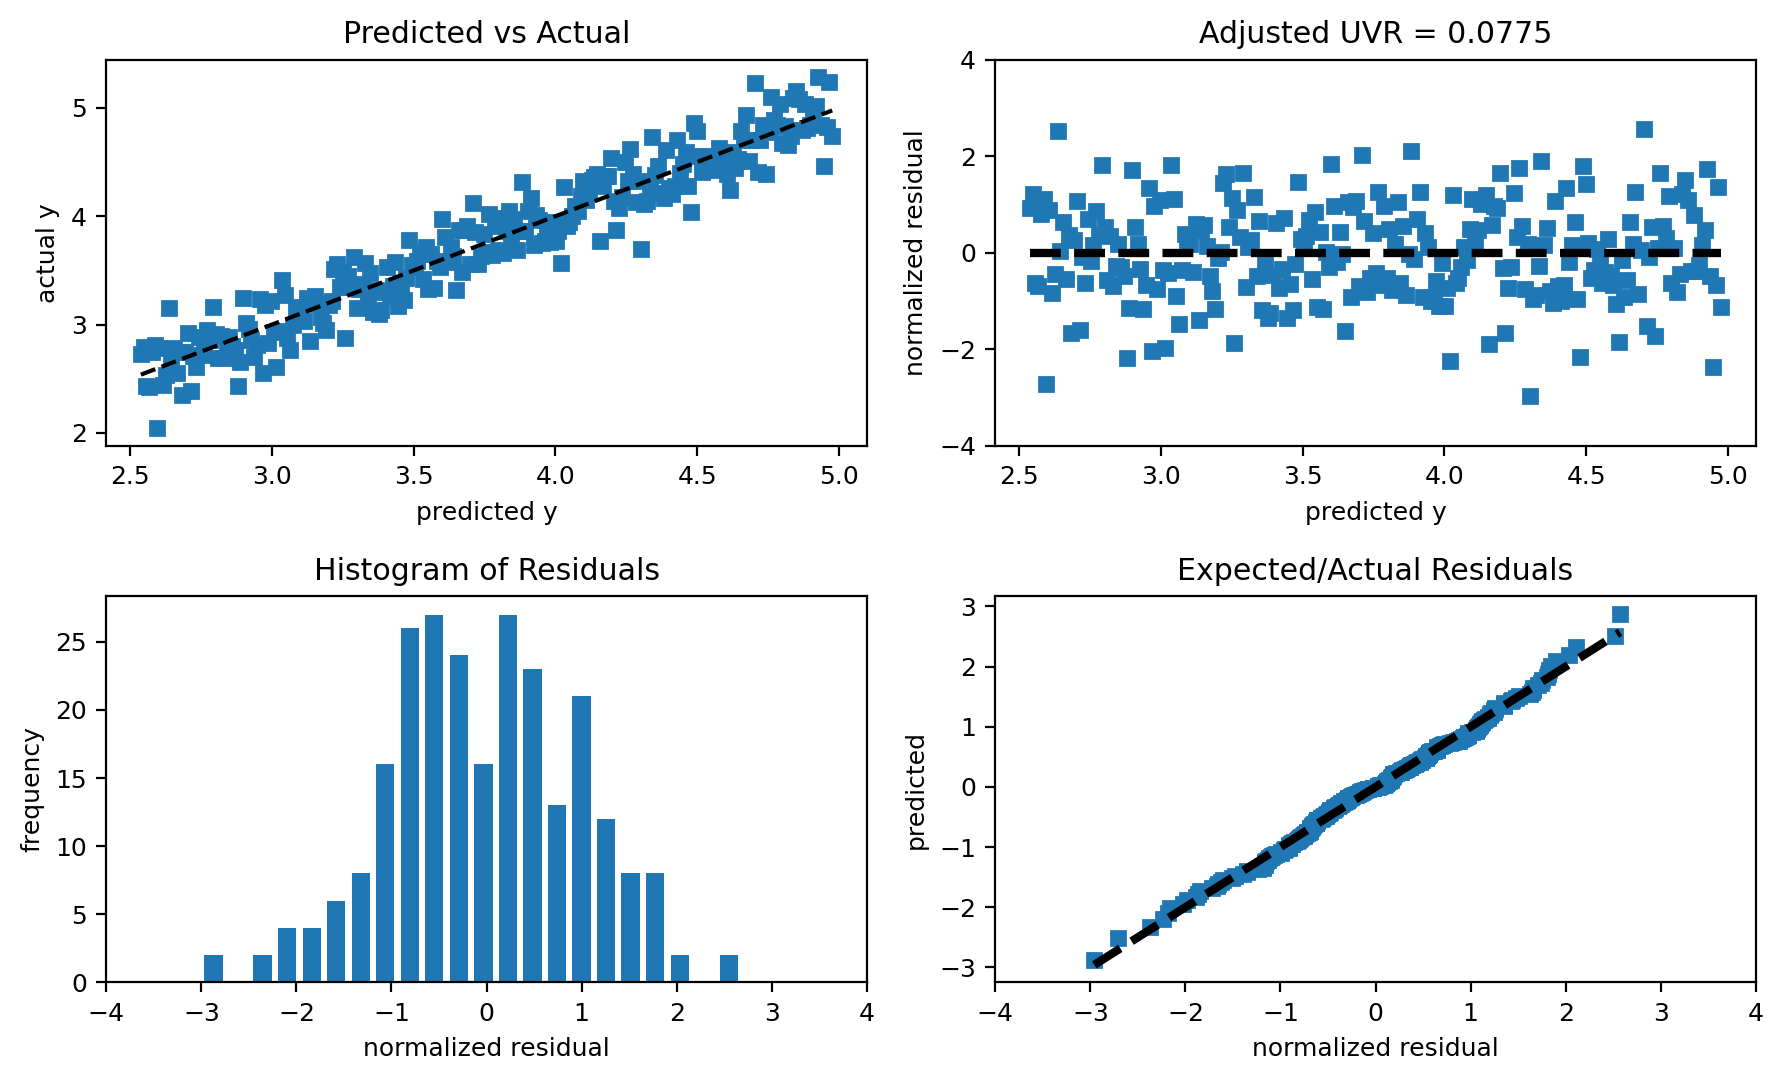

In [14]:
classlib4334.advanced_residual_analysis(linear_model, x, y, pfit, vsypred=True, normalize=True)